In [1]:
import os
import io
import numpy as np
import torch
import torch.onnx
from src.crowd_count import CrowdCounter
from src import network

In [2]:
model_path = '/Users/iPrince/Downloads/Crowd Estimation using CCMTL/saved_models/cmtl_shtechA_1.pth'

In [3]:
model = CrowdCounter()

In [4]:
print(model)

CrowdCounter(
  (CCN): CMTL(
    (base_layer): Sequential(
      (0): Conv2d(
        (conv): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu): PReLU(num_parameters=1)
      )
      (1): Conv2d(
        (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): PReLU(num_parameters=1)
      )
    )
    (hl_prior_1): Sequential(
      (0): Conv2d(
        (conv): Conv2d(32, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu): PReLU(num_parameters=1)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(
        (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): PReLU(num_parameters=1)
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(
        (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): PReLU(num_parameters=

In [5]:
model.load_state_dict(torch.load(model_path), strict=False)
print(model.state_dict())

OrderedDict([('CCN.base_layer.0.conv.weight', tensor([[[[-4.0694e-03,  1.0407e-02, -1.4446e-02,  ..., -1.7931e-02,
            9.1335e-03,  5.0918e-03],
          [-6.5098e-03, -4.5831e-03, -5.3345e-03,  ...,  8.8647e-03,
           -4.1423e-03, -1.0287e-02],
          [-9.7612e-03, -6.2813e-03, -3.2977e-03,  ...,  4.8784e-03,
           -1.1040e-02,  4.1631e-03],
          ...,
          [ 4.6749e-03, -5.5044e-03, -4.0573e-03,  ..., -4.5578e-03,
            1.2972e-02, -3.7506e-03],
          [ 3.8839e-03, -5.4501e-03, -1.4538e-02,  ..., -2.9207e-03,
            4.3057e-03,  1.9076e-02],
          [ 5.9996e-04,  6.4717e-03, -4.4016e-03,  ...,  2.8323e-03,
           -2.4059e-02,  5.8355e-03]]],


        [[[ 1.5000e-02,  1.3304e-03,  5.7629e-03,  ..., -4.4677e-03,
           -2.9917e-02,  5.7949e-03],
          [ 4.4295e-03, -1.4016e-03, -1.1129e-02,  ..., -6.6570e-03,
            9.4832e-03,  1.1974e-03],
          [-1.0056e-03, -1.0871e-02, -7.4451e-04,  ..., -1.1776e-02,
          

         [[ 0.0038]]]])), ('CCN.de_stage_2.6.conv.bias', tensor([0.0004]))])


In [6]:
batch_size = 1
x = torch.randn(batch_size, 1, 224, 224)
torch_out = torch.onnx._export(model, x, "Crowd_Counting.onnx", export_params=True)

C:\Users\iPrince\Downloads\Crowd Estimation using CCMTL\src\crowd_count.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  density_cls_prob = F.softmax(density_cls_score)


In [7]:
print(torch_out)

tensor([[[[0.0016, 0.0016, 0.0016,  ..., 0.0016, 0.0016, 0.0016],
          [0.0016, 0.0017, 0.0017,  ..., 0.0017, 0.0017, 0.0015],
          [0.0016, 0.0016, 0.0017,  ..., 0.0016, 0.0017, 0.0016],
          ...,
          [0.0016, 0.0017, 0.0017,  ..., 0.0017, 0.0017, 0.0015],
          [0.0016, 0.0016, 0.0017,  ..., 0.0016, 0.0017, 0.0016],
          [0.0016, 0.0017, 0.0017,  ..., 0.0017, 0.0017, 0.0016]]]],
       grad_fn=<ReluBackward1>)


In [8]:
import onnx
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object
model_onnx = onnx.load("Crowd_Counting.onnx")

# prepare the caffe2 backend for executing the model this converts the ONNX model into a
# Caffe2 NetDef that can execute it. Other ONNX backends, like one for CNTK will be
# availiable soon.
prepared_backend = onnx_caffe2_backend.prepare(model_onnx)

# run the model in Caffe2

# Construct a map from input names to Tensor data.
# The graph of the model itself contains inputs for all weight parameters, after the input image.
# Since the weights are already embedded, we just need to pass the input image.
# Set the first input.
W = {model_onnx.graph.input[0].name: x.data.numpy()}

# Run the Caffe2 net:
c2_out = prepared_backend.run(W)[0]

# Verify the numerical correctness upto 3 decimal places
np.testing.assert_almost_equal(torch_out.data.cpu().numpy(), c2_out, decimal=3)

print("Exported model has been executed on Caffe2 backend, and the result looks good!")

Exported model has been executed on Caffe2 backend, and the result looks good!


In [10]:
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

In [12]:
# Some standard imports
from caffe2.proto import caffe2_pb2
from caffe2.python import core, net_printer, visualize, workspace, utils

import numpy as np
import os
import subprocess
from PIL import Image
from matplotlib import pyplot
#from skimage import io, transform

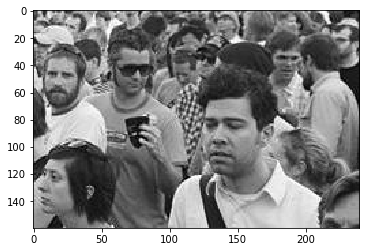

In [13]:
import cv2
img = cv2.imread('/Users/iPrince/Downloads/Crowd Estimation using CCMTL/data/formatted_trainval/shanghaitech_part_A_patches_9/train/3_6.jpg')
from matplotlib import pyplot as plt
plt.imshow(img)

(160, 240, 3)
(224, 224, 3)
(1, 1, 224, 224)


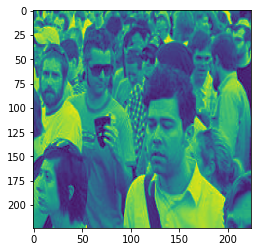

In [14]:
print(img.shape)
dim = (224,224)
img_in = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
print(img_in.shape)
gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
temp = gray.reshape(1,1,224,224)
print(temp.shape)

In [15]:
workspace.RunNetOnce(init_net)
workspace.RunNetOnce(predict_net)

# Caffe2 has a nice net_printer to be able to inspect what the net looks like and identify
# what our input and output blob names are.
print(net_printer.to_string(predict_net))

torch-jit-export_predict = core.Net('torch-jit-export_predict')
torch-jit-export_predict.Conv(['0', '1', '2'], ['57'], group=1, dilations=[1, 1], kernels=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1])
torch-jit-export_predict.PRelu(['57', '3'], ['58'])
torch-jit-export_predict.Conv(['58', '4', '5'], ['59'], group=1, dilations=[1, 1], kernels=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1])
torch-jit-export_predict.PRelu(['59', '6'], ['60'])
torch-jit-export_predict.Conv(['60', '7', '8'], ['61'], group=1, dilations=[1, 1], kernels=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1])
torch-jit-export_predict.PRelu(['61', '9'], ['62'])
torch-jit-export_predict.MaxPool(['62'], ['63'], kernels=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2])
torch-jit-export_predict.Conv(['63', '10', '11'], ['64'], group=1, dilations=[1, 1], kernels=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1])
torch-jit-export_predict.PRelu(['64', '12'], ['65'])
torch-jit-export_predict.MaxPool(['65'], ['66'], kernels=[2, 2], pads=[0, 0, 0, 0], stride

In [17]:
workspace.FeedBlob("57", np.array(gray).astype(np.float32))

True

In [18]:
workspace.RunNetOnce(predict_net)

True

In [19]:
img_out = workspace.FetchBlob("91")

In [20]:
print(img_out)

[[[[0.00155038 0.00156283 0.00158133 ... 0.00156203 0.00158162
    0.00162219]
   [0.00164552 0.00169476 0.0016721  ... 0.00169505 0.00167242
    0.0015279 ]
   [0.00159543 0.00162279 0.00166245 ... 0.00162336 0.00166186
    0.00162378]
   ...
   [0.00164444 0.00169426 0.00167169 ... 0.00169499 0.00167221
    0.00152892]
   [0.00159551 0.00162306 0.00166331 ... 0.00162334 0.00166269
    0.00162427]
   [0.00164204 0.00167449 0.00166421 ... 0.00167436 0.00166452
    0.00160715]]]]


In [22]:
print(np.sum(img_out))

83.40685
